0) **Imports**

In [1]:
import os, sys
from timeit import default_timer as timer
import dolfin as df # Fenics : dolfin + ufl + FIAT + ...
import numpy as np
import matplotlib.pyplot as plt

# fetricks is a set of utilitary functions to facilitate our lives
from fetricks.mechanics.elasticity_conversions import youngPoisson2lame
from fetricks import symgrad_mandel

# DDfenics imports
from ddfenics.dd.ddmaterial import DDMaterial 
from ddfenics.dd.ddmetric import DDMetric
from ddfenics.dd.ddfunction import DDFunction
from ddfenics.dd.ddbilinear import DDBilinear
from ddfenics.dd.ddproblem import DDProblem
from ddfenics.dd.ddsolver import DDSolver

1) **Consititutive behaviour Definition**

shuffling
[[134.61538462  57.69230769   0.        ]
 [ 57.69230769 134.61538462   0.        ]
 [  0.           0.          76.92307692]]
[[3.84305738e+02 1.56426217e+02 2.67929988e-11]
 [1.56426217e+02 4.65982492e+02 1.29951279e-10]
 [2.67929988e-11 1.29951279e-10 1.26672726e+02]]
<function symgrad_mandel at 0x7f8cf921ec10>


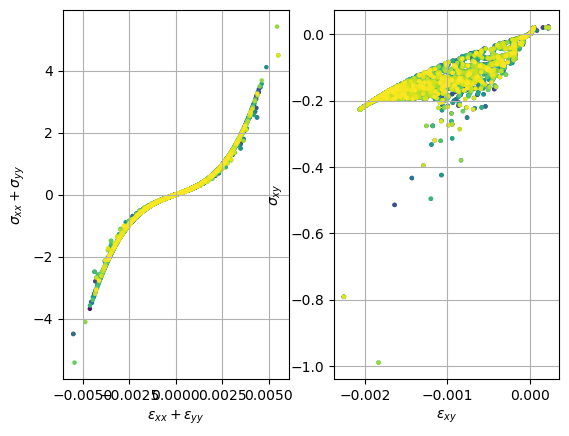

In [2]:
database_file = 'database_ref.txt' # previous computed

metric = {'YOUNG_MODULUS': 100.0,
          'POISSON_RATIO': 0.3}
lamb, mu = youngPoisson2lame(metric['POISSON_RATIO'], metric['YOUNG_MODULUS']) 

Cmat = np.array( [[lamb + 2*mu, lamb, 0], [lamb, lamb + 2*mu, 0], [0, 0, 2*mu]] )

ddmat = DDMaterial(database_file, Cmat)  # replaces sigma_law = lambda u : ...
print(ddmat.C)
ddmat.estimateC()
print(ddmat.C)
print(ddmat.grad)

ddmat.plotDB()

2) **Mesh** (Unchanged) 

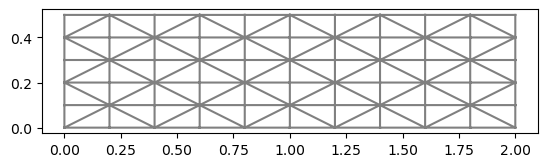

In [3]:
Nx =  10 # x10
Ny =  5 # x10
Lx = 2.0
Ly = 0.5
mesh = df.RectangleMesh(df.Point(0.0,0.0) , df.Point(Lx,Ly), Nx, Ny, 'left/right');
df.plot(mesh);

3) **Mesh regions** (Unchanged)

In [4]:
leftBnd = df.CompiledSubDomain('near(x[0], 0.0) && on_boundary')
rightBnd = df.CompiledSubDomain('near(x[0], Lx) && on_boundary', Lx=Lx)

clampedBndFlag = 1
loadBndFlag = 2
boundary_markers = df.MeshFunction("size_t", mesh, dim=1, value=0)
leftBnd.mark(boundary_markers, clampedBndFlag)
rightBnd.mark(boundary_markers, loadBndFlag)

dx = df.Measure('dx', domain=mesh)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

4) **Spaces**

In [7]:
Uh = df.VectorFunctionSpace(mesh, "Lagrange", 1) # Unchanged
bcL = df.DirichletBC(Uh, df.Constant((0.0, 0.0)), boundary_markers, clampedBndFlag) # Unchanged

# Space for stresses and strains
Sh0 = df.VectorFunctionSpace(mesh, 'DG', degree = 0 , dim = 3) 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


5) **Variational Formulation**: <br>

- Strong format: 
$$
\begin{cases}
div \sigma = 0 \quad \text{in} \, \Omega \\
u = 0 \quad \text{on} \, \Gamma_1 \\
\varepsilon = \nabla^s u \quad \text{in} \, \Omega \\
\sigma  n  = t \quad \text{on} \, \Gamma_2 \\
\end{cases}
$$ 
- DD equilibrium subproblem: Given $(\varepsilon^*, \sigma^*) \in Z_h$, solve for $(u,\eta) \in U_h$  
$$
\begin{cases}
(\mathbb{C} \nabla^s u , \nabla^s v ) = (\mathbb{C} \varepsilon^* , \nabla^s v ) \quad \forall v \in U_h, \\
(\mathbb{C} \nabla^s \eta , \nabla^s \xi ) = \Pi_{ext}(\xi) - (\sigma^* , \nabla^s \xi ) \quad \forall \xi \in U_h \\
\end{cases}
$$
- Updates:
$$
\begin{cases}
\varepsilon = \nabla^s u \\
\sigma = \sigma^* + \mathbb{C} \nabla^s \eta
\end{cases}
$$
- DD ''bilinear'' form : $(\bullet , \nabla^s v)$ or sometimes  $(\mathbb{C} \nabla^s \bullet, \nabla^s v)$ 

In [8]:
# Unchanged
ty = -0.1
traction = df.Constant((0.0, ty))

u = df.TrialFunction(Uh) 
v = df.TestFunction(Uh)
b = df.inner(traction,v)*ds(loadBndFlag)

a = DDBilinear(ddmat, dx, u, v) # replaces df.inner(sig(u) , df.grad(v))*dx

6) **Statement and Solving the problem** <br> 
- DDProblem : States DD equilibrium subproblem and updates.
- DDSolver : Implements the alternate minimization using SKlearn NearestNeighbors('ball_tree', ...) searchs for the projection onto data.
- Stopping criteria: $\|d_k - d_{k-1}\|/energy$

In [9]:
# Extended solution : replaces u = df.Function(Uh)
sol = {"state_mech" : [DDFunction(Sh0), DDFunction(Sh0)], # mechanical states (eps, sig)
       "state_db": [DDFunction(Sh0), DDFunction(Sh0)],  # database states (eps, sig)
       "u" : df.Function(Uh)} # displacemens

# replaces df.LinearVariationalProblem(a, b, uh, bcs = [bcL])
problem = DDProblem(a, b, sol, [bcL], metric = DDMetric(ddmat.C, V = Sh0, dx = dx)) 

start = timer()
#replaces df.LinearVariationalSolver(problem)
solver = DDSolver(problem, opInit = 'random', seed = 1)
tol = 1e-7
hist = solver.solve(tol = tol, maxit = 100);

end = timer()

uh = sol["u"]
normL2 = df.assemble(df.inner(uh,uh)*dx)
normL2_ref = 0.00046895042573293067

print("Time spent: ", end - start)
print("Norm L2: ", normL2)
print("Norm L2 (Ref)",  normL2_ref)
print("Relative Error",  np.abs(normL2_ref - normL2)/normL2_ref)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

7) **Playing around**

a) *Convergence*

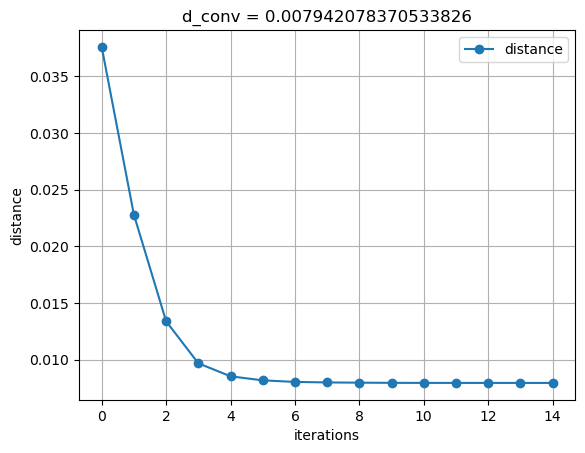

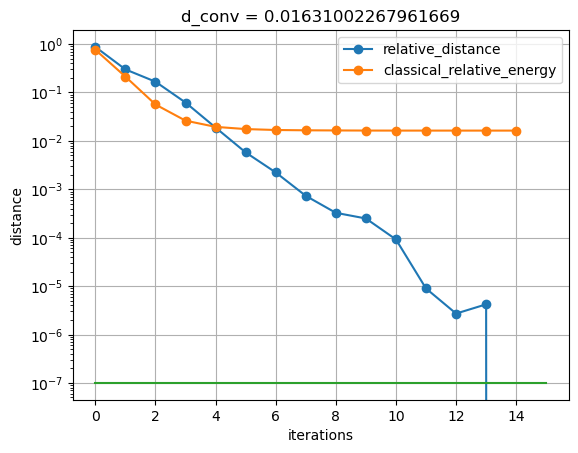

In [10]:
hist = solver.hist

fig = plt.figure(1)
plt.title('d_conv = {0}'.format(hist['distance'][-1]))
plt.plot(hist['distance'], 'o-', label = "distance")
plt.xlabel('iterations')
plt.ylabel('distance')
plt.legend(loc = 'best')
plt.grid()

fig = plt.figure(2)
plt.title('d_conv = {0}'.format(hist['relative_energy'][-1]))
plt.plot(hist['relative_distance'], 'o-', label = "relative_distance")
plt.plot(hist['classical_relative_energy'], 'o-' , label = "classical_relative_energy")
plt.plot([0,len(hist['relative_energy'])],[tol,tol])
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('distance')
plt.legend(loc = 'best')
plt.grid()

b) *Scatter*

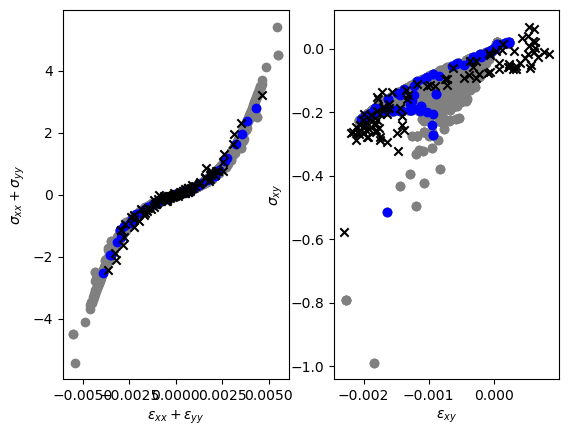

In [11]:
state_mech = sol["state_mech"]
state_db = sol["state_db"]

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.set_xlabel(r'$\epsilon_{xx}+\epsilon_{yy}$')
ax1.set_ylabel(r'$\sigma_{xx}+\sigma_{yy}$')
ax1.scatter(ddmat.DB[:, 0, 0] + ddmat.DB[:, 0, 1], ddmat.DB[:, 1, 0] + ddmat.DB[:, 1, 1], c='gray')
ax1.scatter(state_db[0].data()[:,0]+state_db[0].data()[:,1],state_db[1].data()[:,0]+state_db[1].data()[:,1], c='blue')
ax1.scatter(state_mech[0].data()[:,0]+state_mech[0].data()[:,1],state_mech[1].data()[:,0]+state_mech[1].data()[:,1], marker = 'x', c='black' )

ax2.set_xlabel(r'$\epsilon_{xy}$')
ax2.set_ylabel(r'$\sigma_{xy}$')
ax2.scatter(ddmat.DB[:, 0, 2], ddmat.DB[:, 1, 2], c='gray')
ax2.scatter(state_db[0].data()[:,2], state_db[1].data()[:,2], c='blue')
ax2.scatter(state_mech[0].data()[:,2], state_mech[1].data()[:,2], marker = 'x', c='black')

c) *Pos-Processing*

In [12]:
import fetricks.fenics.postprocessing.wrapper_io as iofe
from fetricks.fenics.la.wrapper_solvers import local_project

uh.rename('uh', '')
state_mech[1].rename('sigma_mech', '')
state_db[1].rename('sigma_db', '')

iofe.exportXDMF_gen("bar_dd.xdmf" , {'vertex': [uh], 'cell': [state_mech[1], state_db[1]]})

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
terminate called after throwing an instance of 'XdmfError'
  what():  ':' not found in content generateHeavyControllers in XdmfCoreItemFactory -- double check an HDF5 data set is specified for the file

Loguru caught a signal: SIGABRT
Stack trace:
59      0x561ca00a13f5 paraview(+0xd3f5) [0x561ca00a13f5]
58      0x7ff8c2093e40 __libc_start_main + 128
57      0x7ff8c2093d90 /usr/bin/../lib/x86_64-linux-gnu/libc.so.6(+0x29d90) [0x7ff8c2093d90]
56      0x561ca00a00a3 paraview(+0xc0a3) [0x561ca00a00a3]
55      0x7ff8c07d9ce4 QCoreApplication::exec() + 148
54      0x7ff8c07d174b QEventLoop::e

34304

d) Less Data

shuffling
(1001, 2, 3)


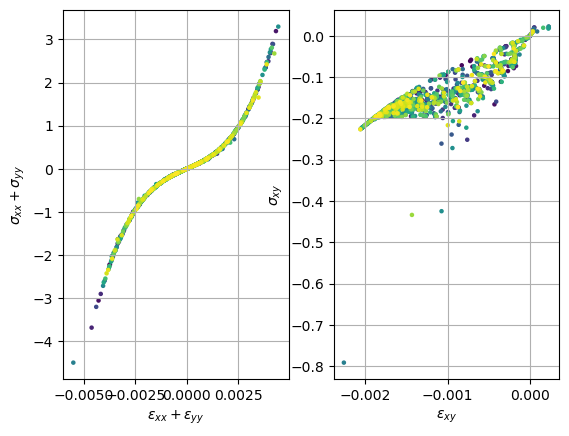

In [15]:
ddmat = DDMaterial(ddmat.DB[:1000], Cmat)  # replaces sigma_law = lambda u : ...
ddmat.estimateC()

ddmat.plotDB()

print(ddmat.DB.shape)

In [16]:
a = DDBilinear(ddmat, dx, u, v) # replaces df.inner(sig(u) , df.grad(v))*dx

sol = {"state_mech" : [DDFunction(Sh0), DDFunction(Sh0)], # mechanical states (eps, sig)
       "state_db": [DDFunction(Sh0), DDFunction(Sh0)],  # database states (eps, sig)
       "u" : df.Function(Uh)} # displacemens

problem = DDProblem(a, b, sol, [bcL], metric = DDMetric(ddmat.C, V = Sh0, dx = dx)) 

solver = DDSolver(problem, opInit = 'zero', seed = 1)
tol = 1e-7
hist = solver.solve(tol = tol, maxit = 100);

	Inner Iteration #  1 ,- Relative Error =  8.682148e-01
	Inner Iteration #  2 ,- Relative Error =  3.020973e-01
	Inner Iteration #  3 ,- Relative Error =  1.569949e-01
	Inner Iteration #  4 ,- Relative Error =  5.635343e-02
	Inner Iteration #  5 ,- Relative Error =  2.034711e-02
	Inner Iteration #  6 ,- Relative Error =  5.871496e-03
	Inner Iteration #  7 ,- Relative Error =  1.473539e-03
	Inner Iteration #  8 ,- Relative Error =  3.361302e-04
	Inner Iteration #  9 ,- Relative Error =  1.035509e-05
	Inner Iteration # 10 ,- Relative Error =  1.562630e-05
	Inner Iteration # 11 ,- Relative Error =  0.000000e+00
